In [1]:
import os, sys
import pyspark
import pyspark.sql
from pyspark.sql import Row

sc = False
spark = False
def stop_spark():
    global sc
    sc.stop()
    print("PySpark stopped...")

def start_spark(cores):
    global sc
    global spark
    os.environ["JAVA_HOME"]="/lrz/sys/compilers/java/jdk1.8.0_112"
    APP_NAME = "PySpark Lecture"
    SPARK_MASTER="local["+ cores + "]"
    conf=pyspark.SparkConf()
    conf=pyspark.SparkConf().setAppName(APP_NAME).set("spark.local.dir", os.path.join(os.getcwd(), "tmp"))
    sc    = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
    spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()
    print("PySpark initiated...")
    
file = "/naslx/projects/pn69si/mnmda001/students/data/nasa/NASA_access_log_Jul95"
file

'/naslx/projects/pn69si/mnmda001/students/data/nasa/NASA_access_log_Jul95'

In [2]:
start_spark("1")

PySpark initiated...


In [3]:
import time

#5.2 Create a Spark-SQL table with fields for IP/Host and Response Code from the NASA Log file! 
def nasa_to_row(line):
    parts = line.split(" ")
    r = -1
    if len(parts) < 9:
        r = -1
    else:
        r = parts[len(parts)-2]
    row = Row(
      ip=parts[0],
      resp=r
    )
    return row
# Load the text file using the SparkContext
nasa = sc.textFile(file)
rows = nasa.map(nasa_to_row)
df = rows.toDF()

#5.4 Cachen Sie den Dataframe und führen Sie dieselbe Query nochmals aus! Messen Sie die Laufzeit für das Cachen und für die Ausführungszeit der Query!
start = time.time()
df.cache()
exe = time.time()-start
print ("Cache op took: " + str(exe) + " Seconds")

start = time.time()
df.registerTempTable("nasa")

#5.3 Run an SQL query that outputs the number of occurrences of each HTTP response code!
# Generate a new DataFrame with SQL using the SparkSession
nasa_count = spark.sql("""
SELECT
  resp,
  count(*) as Count
  FROM nasa
  where resp is not null
  group by resp
""")
nasa_count.show()
exe = time.time()-start
print ("Query took: " + str(exe) + " Seconds")

start = time.time()
nasa_count = spark.sql("""
SELECT
  resp,
  count(*) as Count
  FROM nasa
  where resp is not null
  group by resp
""")
nasa_count.show()
exe = time.time()-start
print ("Cached Query took: " + str(exe) + " Seconds")

# Go back to an RDD
#job_counts.rdd.collect()

df

Cache op took: 0.19298696517944336 Seconds
+----+-------+
|resp|  Count|
+----+-------+
|  -1|      6|
| 200|1701534|
| 302|  46573|
| 501|     14|
| 404|  10845|
| 403|     54|
| 500|     62|
| 304| 132627|
+----+-------+

Query took: 33.28501796722412 Seconds
+----+-------+
|resp|  Count|
+----+-------+
|  -1|      6|
| 200|1701534|
| 302|  46573|
| 501|     14|
| 404|  10845|
| 403|     54|
| 500|     62|
| 304| 132627|
+----+-------+

Cached Query took: 1.7881879806518555 Seconds


DataFrame[ip: string, resp: string]

5.5. Implement the same Query using the Dataframe API!

In [5]:
# Load the text file using the SparkContext
nasa = sc.textFile(file)
rows = nasa.map(nasa_to_row)
#rows.first()
df = rows.toDF()

# Go back to an RDD
#job_counts.rdd.collect()

test = df.groupBy('resp').agg({'resp': 'count'})
test.show()

+----+-----------+
|resp|count(resp)|
+----+-----------+
|  -1|          6|
| 200|    1701534|
| 302|      46573|
| 501|         14|
| 404|      10845|
| 403|         54|
| 500|         62|
| 304|     132627|
+----+-----------+



PySpark stopped...
PySpark initiated...
PySpark stopped...
PySpark initiated...


{'8': [5.299163818359375, 0.32302236557006836],
 '16': [5.501942157745361, 0.3031125068664551]}

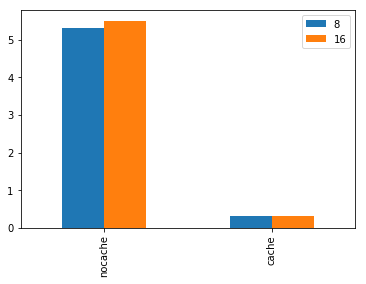

In [9]:
#5.6 Führen Sie diesselbe Query mit/ohne Cache und 8, 16 Cores aus! Dokumentieren und erklären Sie das Ergebnis!
import pandas as pd


# Load the text file using the SparkContext
t = [0,0,0,0]

stop_spark()
start_spark("8")
nasa8 = sc.textFile(file)
rows8 = nasa8.map(nasa_to_row)
df8 = rows8.toDF()
df8.cache()

start = time.time()
res = df8.groupBy('resp').agg({'resp': 'count'}).collect()
t[0] = time.time()-start

start = time.time()
res = df8.groupBy('resp').agg({'resp': 'count'}).collect()
t[2] = time.time()-start

stop_spark()
start_spark("16")

nasa16 = sc.textFile(file)
rows16 = nasa16.map(nasa_to_row)
df16 = rows16.toDF()
df16.cache()


start = time.time()
res = df16.groupBy('resp').agg({'resp': 'count'}).collect()
t[1] = time.time()-start

start = time.time()
res = df16.groupBy('resp').agg({'resp': 'count'}).collect()
t[3] = time.time()-start

t
layout = {'8': [float(t[0]),float(t[2])],
         '16': [float(t[1]),float(t[3])]}
df = pd.DataFrame(layout,index = ['nocache', 'cache'])
df
#test = df.groupBy('resp').agg({'resp': 'count'})
df.plot.bar()
#res = pd.DataFrame({'Runtime in Sec': t},index = ['Generate', 'Sort','Validate'])
layout

Anscheinend hat die Anzahl der Cores keinen Einfluss auf die schnelle der Verarbeitung. Serieller Falschenhals ist das laden in den RAM.
Vermutlich Amdahl Law (Gedeckt durch experiment weiter unten) Bei 8 Cores scheint eine Sättigung einzutreten und der Lineare Anteil zu dominieren

PySpark stopped...
PySpark initiated...
PySpark stopped...
PySpark initiated...


[Row(resp='-1', count(resp)=6),
 Row(resp='200', count(resp)=1701534),
 Row(resp='302', count(resp)=46573),
 Row(resp='501', count(resp)=14),
 Row(resp='404', count(resp)=10845),
 Row(resp='403', count(resp)=54),
 Row(resp='500', count(resp)=62),
 Row(resp='304', count(resp)=132627)]

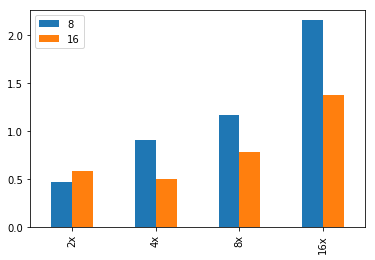

In [13]:
#5.7 Performance Analysis:
#* Create RDDs with 2x, 4x, 8x and 16x of the size of the NASA log dataset! Persist the dataset in the Spark Cache! Use an appropriate number of cores (e.g. 8 or 16)!
#* Measure and plot the response times for all datasets using a constant number of cores!
#* Plot the results!
#* Explain the results!
def eval_runtime(rows):
    df = rows.toDF()
    df.cache().count()
    start = time.time()
    test = df.groupBy('resp').agg({'resp': 'count'})
    test.collect()
    return time.time()-start

stop_spark()
start_spark("8")
nasa8 = sc.textFile(file)
rows = nasa8.map(nasa_to_row)
rows8_2 = rows.union(rows)
rows8_4 = rows8_2.union(rows8_2)
rows8_8 = rows8_4.union(rows8_4)
rows8_16 = rows8_8.union(rows8_8)

a = eval_runtime(rows8_2)
b = eval_runtime(rows8_4)
c = eval_runtime(rows8_8)
d = eval_runtime(rows8_16)

layout = {'8': [float(a),float(b),float(c),float(d)]}

stop_spark()
start_spark("16")
nasa8 = sc.textFile(file)
rows = nasa8.map(nasa_to_row)
rows8_2 = rows.union(rows)
rows8_4 = rows8_2.union(rows8_2)
rows8_8 = rows8_4.union(rows8_4)
rows8_16 = rows8_8.union(rows8_8)

a = eval_runtime(rows8_2)
b = eval_runtime(rows8_4)
c = eval_runtime(rows8_8)
d = eval_runtime(rows8_16)

layout['16'] = [float(a),float(b),float(c),float(d)]

df = pd.DataFrame(layout,index = ['2x', '4x','8x','16x'])
df
#test = df.groupBy('resp').agg({'resp': 'count'})
df.plot.bar()
res

5.8 Strong Scaling
* Measure the runtime for the query for 8, 16, 32, 64, 128, 256 cores for 1x and 16x datasets! Datasets cached in Memory!
* Compute the speedup and efficiency!
* Plot the responses!
* Explain the results! -> 1 bis 8 Cores Log. Verbesserung in der Laufzeit, danach keine Verbesserung mehr (Amdahls Law siehe oben)

PySpark stopped...
PySpark initiated...
PySpark stopped...
PySpark initiated...
PySpark stopped...
PySpark initiated...
PySpark stopped...
PySpark initiated...
PySpark stopped...
PySpark initiated...


[Row(resp='-1', count(resp)=6),
 Row(resp='200', count(resp)=1701534),
 Row(resp='302', count(resp)=46573),
 Row(resp='501', count(resp)=14),
 Row(resp='404', count(resp)=10845),
 Row(resp='403', count(resp)=54),
 Row(resp='500', count(resp)=62),
 Row(resp='304', count(resp)=132627)]

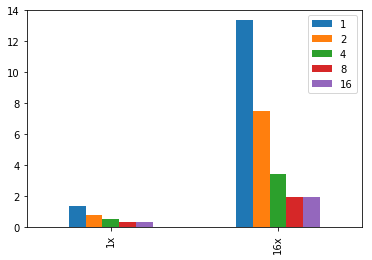

In [14]:
def eval_runtime(rows):
    df = rows.toDF()
    df.cache().count()
    start = time.time()
    test = df.groupBy('resp').agg({'resp': 'count'})
    test.collect()
    return time.time()-start

layout = {}

stop_spark()
start_spark("1")
nasa8 = sc.textFile(file)
rows = nasa8.map(nasa_to_row)
rows8_2 = rows.union(rows)
rows8_4 = rows8_2.union(rows8_2)
rows8_8 = rows8_4.union(rows8_4)
rows8_16 = rows8_8.union(rows8_8)

a = eval_runtime(rows)
b = eval_runtime(rows8_16)

layout['1'] = [float(a),float(b)]

stop_spark()
start_spark("2")
nasa8 = sc.textFile(file)
rows = nasa8.map(nasa_to_row)
rows8_2 = rows.union(rows)
rows8_4 = rows8_2.union(rows8_2)
rows8_8 = rows8_4.union(rows8_4)
rows8_16 = rows8_8.union(rows8_8)

a = eval_runtime(rows)
b = eval_runtime(rows8_16)

layout['2'] = [float(a),float(b)]

stop_spark()
start_spark("4")
nasa8 = sc.textFile(file)
rows = nasa8.map(nasa_to_row)
rows8_2 = rows.union(rows)
rows8_4 = rows8_2.union(rows8_2)
rows8_8 = rows8_4.union(rows8_4)
rows8_16 = rows8_8.union(rows8_8)

a = eval_runtime(rows)
b = eval_runtime(rows8_16)

layout['4'] = [float(a),float(b)]

stop_spark()
start_spark("8")
nasa8 = sc.textFile(file)
rows = nasa8.map(nasa_to_row)
rows8_2 = rows.union(rows)
rows8_4 = rows8_2.union(rows8_2)
rows8_8 = rows8_4.union(rows8_4)
rows8_16 = rows8_8.union(rows8_8)

a = eval_runtime(rows)
b = eval_runtime(rows8_16)

layout['8'] = [float(a),float(b)]

stop_spark()
start_spark("16")
nasa8 = sc.textFile(file)
rows = nasa8.map(nasa_to_row)
rows8_2 = rows.union(rows)
rows8_4 = rows8_2.union(rows8_2)
rows8_8 = rows8_4.union(rows8_4)
rows8_16 = rows8_8.union(rows8_8)

a = eval_runtime(rows)
b = eval_runtime(rows8_16)

layout['16'] = [float(a),float(b)]
layout

df = pd.DataFrame(layout,index = ['1x', '16x'])
df
#test = df.groupBy('resp').agg({'resp': 'count'})
df.plot.bar()
res